<a href="https://colab.research.google.com/github/aviral-shrivastava/Sentimental-analysis/blob/main/Distilbert_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 32/32 [05:47<00:00, 10.85s/it, loss=0.0765]


DistilBERT Model Accuracy: 0.94

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.33      0.50         3
     Neutral       0.93      1.00      0.96        13
    Positive       0.94      0.97      0.96        34

    accuracy                           0.94        50
   macro avg       0.96      0.77      0.81        50
weighted avg       0.94      0.94      0.93        50

Predictions saved to 'distilbert_sentiment.csv'.


<ipython-input-4-245ac1f102f1>:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Predicted_Sentiment", data=test_data, palette="viridis")


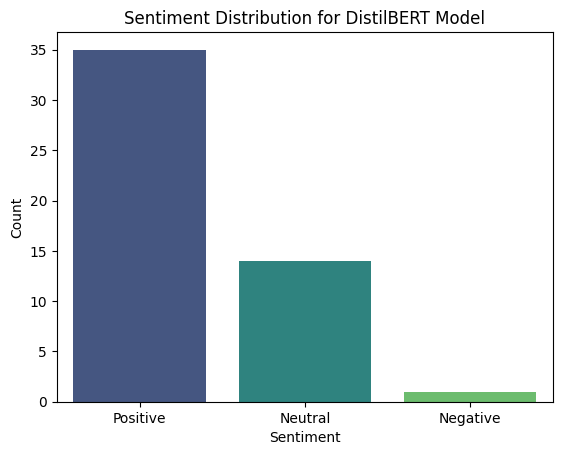

In [ ]:
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AdamW
from torch.utils.data import DataLoader, Dataset
from torch.nn import CrossEntropyLoss
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the datasets
train_data = pd.read_csv("/content/train.csv")
test_data = pd.read_csv("/content/test.csv")

# Preprocessing with DistilBERT Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Define a dictionary to map sentiment labels to numerical values
sentiment_map = {"negative": 0, "neutral": 1, "positive": 2}

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        # Convert the string label to a numerical label using the sentiment_map
        # Strip whitespace and convert to lowercase to handle variations
        label = sentiment_map.get(self.labels[idx].strip().lower(), -1)
        # Raise an error if an unknown label is encountered
        if label == -1:
            raise ValueError(f"Unknown sentiment label: {self.labels[idx]}")

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].squeeze()
        attention_mask = encoding["attention_mask"].squeeze()

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": torch.tensor(label, dtype=torch.long)
        }

# Prepare datasets
train_texts = train_data["tweet_text"].tolist()
train_labels = train_data["sentiment"].tolist()

test_texts = test_data["tweet_text"].tolist()
test_labels = test_data["sentiment"].tolist()

train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load DistilBERT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=3
)  # Assuming 3 sentiment classes (positive, neutral, negative)
model = model.to(device)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = CrossEntropyLoss()

# Training loop
model.train()
epochs = 1
for epoch in range(epochs):
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch {epoch + 1}")
        loop.set_postfix(loss=loss.item())

# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"DistilBERT Model Accuracy: {accuracy:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=["Negative", "Neutral", "Positive"]))

# Create a DataFrame for histogram
test_data["Predicted_Sentiment"] = predictions
sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
test_data["Predicted_Sentiment"] = test_data["Predicted_Sentiment"].map(sentiment_map)

# Save results to CSV
test_data.to_csv("distilbert_sentiment.csv", index=False)
print("Predictions saved to 'distilbert_sentiment.csv'.")

# Plot histogram
sns.countplot(x="Predicted_Sentiment", data=test_data, palette="viridis")
plt.title("Sentiment Distribution for DistilBERT Model")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()
